# CSE251B Project Milestone Starter File

## Step 1: Import Dependencies:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
import tqdm

## Step 2: Load the Dataset

#### You need to describe in your own words what the dataset is about, and use mathematical language and formulate your prediction task on the submitted PDF file for Question 1 Problem A.

#### Here we are loading the dataset from the local directory. And answer Question 1 Problem B

In [3]:
train_npz = np.load('../data/train.npz')
train_data = train_npz['data']
test_npz  = np.load('../data/test_input.npz')
test_data  = test_npz['data']

In [4]:
print(train_data.shape, test_data.shape)

# Split once for later use
X_train = train_data[..., :50, :]
Y_train = train_data[:, 0, 50:, :2]

(10000, 50, 110, 6) (2100, 50, 50, 6)


In [5]:
def plot_heatmap(data, title=None, bins=5):
    plt.figure(figsize=(6, 6))

    x_max = data[..., 0].max()
    x_min = data[..., 0].min()
    y_max = data[..., 1].max()
    y_min = data[..., 1].min()

    plt.hist2d(data[:, 0], data[:, 1], bins=bins, cmap='hot')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title(title)
    plt.colorbar(label='Density')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()

In [6]:
xy_in = train_data[:, :, :50, :2].reshape(-1, 2)
# only find the x, y != 0
xy_in_not_0 = xy_in[(xy_in[:, 0] != 0) & (xy_in[:, 1] != 0)]

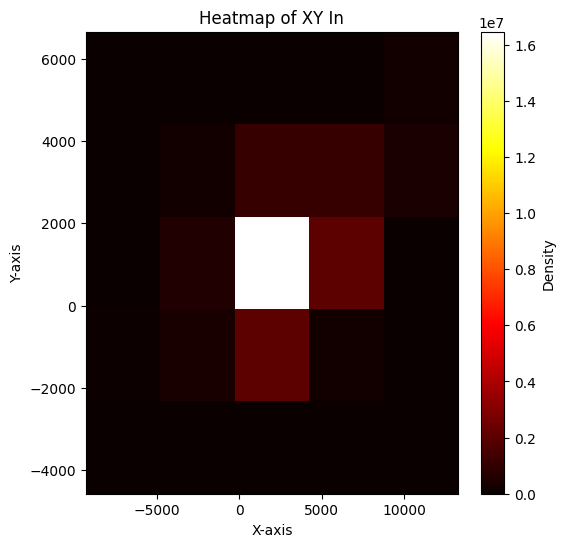

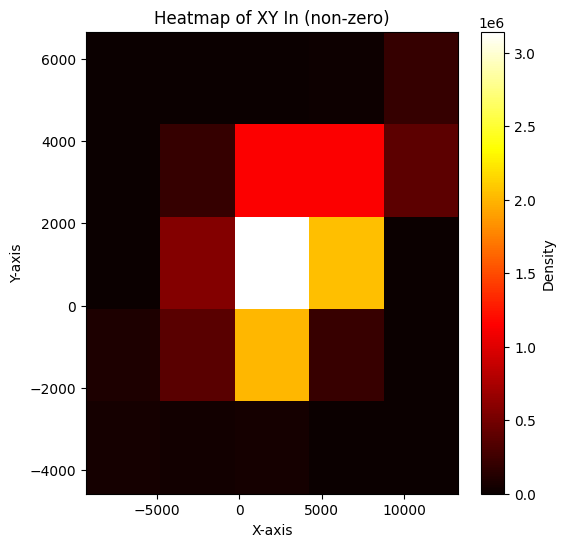

In [7]:
plot_heatmap(xy_in, title='Heatmap of XY In', bins=5)
plot_heatmap(xy_in_not_0, title='Heatmap of XY In (non-zero)', bins=5)

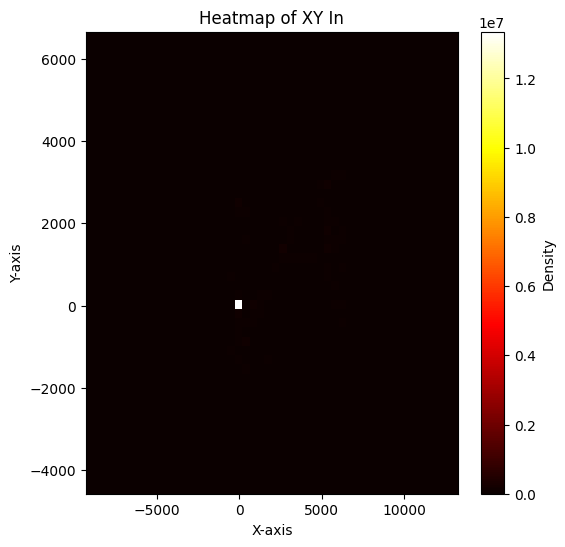

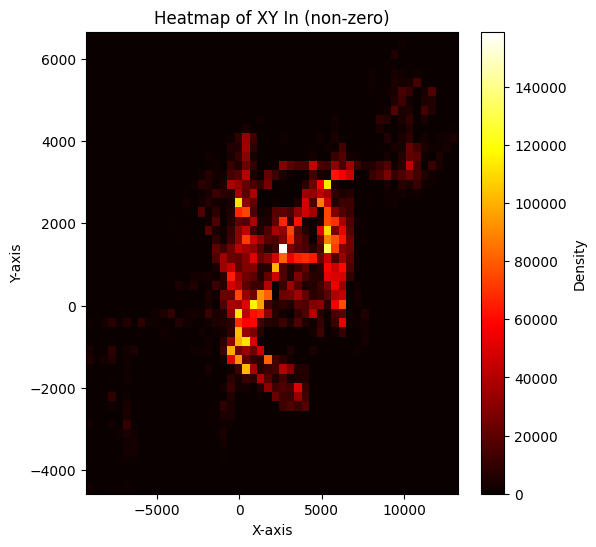

In [8]:
plot_heatmap(xy_in, title='Heatmap of XY In', bins=50)
plot_heatmap(xy_in_not_0, title='Heatmap of XY In (non-zero)', bins=50)

#### Try to play around with dataset for training and testing, make exploratory analysis on the dataset for bonus points(up to 2)

## Step 3: Setting up the Training and Testing

### Example Code:

In [9]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene[:, :50, :].copy()    # (agents=50, time_seq=50, 6)

        # forward-fill any “disappeared” points that got reset to 0
        #    for each agent independently, if pos[t] == (0,0) but pos[t-1]!= (0,0),
        #    replace with the previous frame so that velocity stays 0 instead of a big jump.
        for ag in range(hist.shape[0]):
            pos = hist[ag, :, :2]               # (50,2)
            mask = (pos[:,0]==0) & (pos[:,1]==0)
            for t in range(1, pos.shape[0]):
                if mask[t]:
                    pos[t] = pos[t-1]
            hist[ag, :, :2] = pos

        future = torch.tensor(scene[0, 50:, :2].copy(), dtype=torch.float32)  # (60, 2)
        
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                future = future @ R
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        future = future - origin

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        # forward-fill any “disappeared” points that got reset to 0
        #    for each agent independently, if pos[t] == (0,0) but pos[t-1]!= (0,0),
        #    replace with the previous frame so that velocity stays 0 instead of a big jump.
        for ag in range(hist.shape[0]):
            pos = hist[ag, :, :2]               # (50,2)
            mask = (pos[:,0]==0) & (pos[:,1]==0)
            for t in range(1, pos.shape[0]):
                if mask[t]:
                    pos[t] = pos[t-1]
            hist[ag, :, :2] = pos
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        return data_item

#### Answer Question related to Your Computational Platform and GPU for Question 2 Problem A

In [27]:
torch.manual_seed(251)
np.random.seed(42)

scale = 7.0

N = len(train_data)
val_size = int(0.1 * N)
train_size = N - val_size

train_dataset = TrajectoryDatasetTrain(train_data[:train_size], scale=scale, augment=True)
val_dataset = TrajectoryDatasetTrain(train_data[train_size:], scale=scale, augment=False)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x))
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x))

# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')

Using CUDA GPU


#### Your Model for Question 2 Problem B (Include your model architecture pictures and also can use some mathmatical equations to explain your model in your report)

In [11]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim=50 * 50 * 2, output_dim=60 * 2):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, data):
        x = data.x[..., :2] # (batch*50, 50, 2)
        x = x.reshape(-1, 50 * 50 * 2) # (batch, 5000)
        x = self.linear(x)
        return x.view(-1, 60, 2)

In [12]:
class MLP(nn.Module):
    def __init__(self, input_features, output_features):
        super(MLP, self).__init__()
        
        # Define the layers
        self.flatten = nn.Flatten()
        self.mlp = nn.Sequential(
            nn.Linear(input_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(256, output_features)
        )
    
    def forward(self, data):
        x = data.x
        x = x[:, :, :, :2] # (batch, 50, 50, 2)
        x = x.reshape(-1, 50 * 50 * 6)
        x = self.mlp(x)
        return x.view(-1, 60, 2)

In [13]:
class LearnedVelocityCV(nn.Module):
    def __init__(self, input_features, output_features):
        super().__init__()
        
        self.vel_predictor = nn.Sequential(
            nn.Flatten(),                     # 将 velocity_diff 展平 (B, 49*2)
            nn.Linear(49 * 2, 256),
            nn.ReLU(),
            nn.Linear(256, 60 * 2)            # 输出每帧速度 (B, 60*2)
        )
        
    def forward(self, data):
        x = data.x
        x = x.reshape(-1, 50, 50, 6)          # (B*50, 50*6)
        B = x.size(0)
        x = x.view(B, 50, 50, 6)

        last_pos = x[:, 0, -1, :2]           # (B, 2)
        velocity_diff = x[:, 0, 1:, :2] - x[:, 0, :-1, :2]  # (B, 49, 2)

        # 用 vel_predictor 预测未来每步速度
        pred_vel = self.vel_predictor(velocity_diff)       # (B, 60*2)
        pred_vel = pred_vel.view(B, 60, 2)                 # (B, 60, 2)

        # 位置 = 起点 + 累加速度
        pred_pos = last_pos.unsqueeze(1) + torch.cumsum(pred_vel, dim=1)  # (B, 60, 2)

        return pred_pos

#### This Model will be covered during Week 6 Lecture (If you don't understand it for now, don't worry, we will cover it in the lecture, or you can ask in the office hours)

In [14]:
class LSTM(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=128, output_dim=60 * 2):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, num_layers=2, dropout=0.1)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x = data.x
        x= x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :4] # Only Consider ego agent index 0

        lstm_out, _ = self.lstm(x)
        # lstm_out is of shape (batch_size, seq_len, hidden_dim) and we want the last time step output
        out = self.fc(lstm_out[:, -1, :])
        
        return out.view(-1, 60, 2)

In [15]:
class LSTMwithNeighbors(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=128, cnn_out_dim = 32, output_dim=60 * 2):
        super(LSTMwithNeighbors, self).__init__()
        self.lstm = nn.LSTM(input_dim+32, hidden_dim, batch_first=True, num_layers=2, dropout=0.1)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.cnn_out_dim = cnn_out_dim
        self.neighbor_cnn = nn.Sequential(
            nn.Conv1d(4, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(16, cnn_out_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1)  # 输出 shape: (B*T, cnn_out_dim, 1)
        )
        
    def forward(self, data):
        x = data.x
        x= x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        
        ego_feat = x[:, 0, :, :] # Only Consider ego agent index 0

        neighbor_feat = x[:, 1:, :, :4]     # (B, 49, 50, 4) — pos + vel only
        neighbor_feat = neighbor_feat.permute(0, 2, 3, 1).contiguous()  # (B, 50, 4, 49)
        neighbor_feat = neighbor_feat.view(-1, 4, 49)               # (B*T, 4, 49)

        # 3. CNN to compress neighbor info
        neighbor_enc = self.neighbor_cnn(neighbor_feat)  # (B*T, cnn_out_dim, 1)
        neighbor_enc = neighbor_enc.squeeze(-1).view(-1, 50, self.cnn_out_dim)  # (B, 50, cnn_out_dim)

        # 4. Concatenate ego + neighbor features
        lstm_input = torch.cat([ego_feat, neighbor_enc], dim=-1)  # (B, 50, 6 + cnn_out_dim)
        lstm_out, _ = self.lstm(lstm_input)
        # lstm_out is of shape (batch_size, seq_len, hidden_dim) and we want the last time step output
        out = self.fc(lstm_out[:, -1, :])
        
        return out.view(-1, 60, 2)

In [16]:
class ParallelDecoderLSTM(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=128, output_dim=2, pred_len=60, fc_dim=64):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.pred_len = pred_len
        self.output_dim = output_dim
        self.cnn_out_dim = 32  # Output dimension of CNN for neighbor features
        # Encoder: FC → ReLU → 2-layer LSTM
        self.encoder_fc = nn.Sequential(
            nn.Linear(input_dim, fc_dim),
            nn.ReLU()
        )
        self.encoder = nn.LSTM(input_dim + self.cnn_out_dim, hidden_dim, batch_first=True, num_layers=2, dropout=0.3)
        self.encoder_norm = nn.LayerNorm(hidden_dim)
        self.decoder = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, num_layers=2, dropout=0.3)
        self.decoder_norm = nn.LayerNorm(hidden_dim)
        
        # Learnable decoder token input
        self.decoder_input_tokens = nn.Parameter(torch.randn(1, pred_len, hidden_dim))

        self.neighbor_cnn = nn.Sequential(
            nn.Conv1d(4, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(16, self.cnn_out_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1)  # 输出 shape: (B*T, cnn_out_dim, 1)
        )

        # Output projection to velocity (or position delta)
        self.output_proj = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x = data.x.reshape(-1, 50, 50, 6)
        
        neighbor_feat = x[:, 1:, :, :4]     # (B, 49, 50, 4) — pos + vel only
        neighbor_feat = neighbor_feat.permute(0, 2, 3, 1).contiguous()  # (B, 50, 4, 49)
        neighbor_feat = neighbor_feat.view(-1, 4, 49)               # (B*T, 4, 49)
        # CNN to compress neighbor info
        neighbor_enc = self.neighbor_cnn(neighbor_feat)  # (B*T, cnn_out_dim, 1)
        neighbor_enc = neighbor_enc.squeeze(-1).view(-1, 50, self.cnn_out_dim)  # (B, 50, cnn_out_dim)
        
        x = x[:, 0, :, :4]  # ego agent only, shape (B, 50, 4)
        B = x.shape[0]

        lstm_input = torch.cat([x, neighbor_enc], dim=-1)
        
        # Encoder
        _, (h_n, c_n) = self.encoder(lstm_input)  # (2, B, hidden)

        # Decoder input: expand learnable tokens
        timestep_encoding = torch.linspace(0, 1, steps=self.pred_len, device=x.device).unsqueeze(0).unsqueeze(-1)  # (1, 60, 1)
        decoder_input = h_n[-1].unsqueeze(1).repeat(1, self.pred_len, 1)  # (B, 60, hidden)
        decoder_input = decoder_input + timestep_encoding  # (B, 60, hidden+1)
        # decoder_input = self.decoder_input_tokens.expand(B, -1, -1)  # (B, 60, hidden)

        decoder_output, _ = self.decoder(decoder_input, (h_n, c_n))  # (B, 60, hidden)
        decoder_output = self.decoder_norm(decoder_output)
        
        # Project to output dimension
        pred = self.output_proj(decoder_output)  # (B, 60, 2)

        return pred

In [17]:
class Encoder(nn.Module):
    def __init__(self, input_dim=6, embedding_dim=128, hidden_dim=128, n_layers=2, dropout=0.3):
        super().__init__()
        self.embedding = nn.Linear(input_dim, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x: (seq_len, batch_size, input_dim)
        embedded = self.dropout(nn.functional.relu(self.embedding(x)))
        outputs, (hidden, cell) = self.rnn(embedded)
        return hidden, cell

class Decoder(nn.Module):
    def __init__(self, output_dim=2, embedding_dim=128, hidden_dim=128, n_layers=2, dropout=0.3):
        super().__init__()
        self.embedding = nn.Linear(output_dim, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, dropout=dropout)
        self.output_proj = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, hidden, cell):
        # x: (batch_size, output_dim)
        x = x.unsqueeze(0)  # → (1, batch_size, output_dim)
        embedded = self.dropout(nn.functional.relu(self.embedding(x)))  # (1, B, embed)
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        prediction = self.output_proj(output.squeeze(0))  # (B, output_dim)
        return prediction, hidden, cell

class LSTMEncoderDecoder(nn.Module):
    def __init__(self, input_dim=6, output_dim=2, embedding_dim=128, hidden_dim=256, 
                 n_layers=2, dropout=0.3, pred_len=60, teacher_forcing_ratio=0.5):
        super().__init__()
        self.encoder = Encoder(input_dim, embedding_dim, hidden_dim, n_layers, dropout)
        self.decoder = Decoder(output_dim, embedding_dim, hidden_dim, n_layers, dropout)
        self.pred_len = pred_len
        self.teacher_forcing_ratio = teacher_forcing_ratio

    def forward(self, data):
        x = data.x.reshape(-1, 50, 50, 6)
        x = x[:, 0, :, :]  # (B, 50, 6)
        x = x.permute(1, 0, 2)  # (seq_len=50, B, 6)

        batch_size = x.size(1)
        device = x.device
        hidden, cell = self.encoder(x)

        # First decoder input: last observed position
        decoder_input = x[-1, :, :2]  # 只用坐标部分作为decoder输入
        outputs = torch.zeros(self.pred_len, batch_size, 2, device=device)

        for t in range(self.pred_len):
            out, hidden, cell = self.decoder(decoder_input, hidden, cell)
            outputs[t] = out
            teacher_force = random.random() < self.teacher_forcing_ratio
            decoder_input = data.y.reshape(-1, 60, 2)[:, t, :] if (self.training and teacher_force) else out

        return outputs.permute(1, 0, 2)  # (B, pred_len, 2)

In [ ]:
class LSTMEncoderDecoderWithVelocity(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=128, output_dim=2, pred_len=60):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.pred_len = pred_len

        # CNN to encode 49 neighbors (per time step)
        self.neighbor_cnn = nn.Sequential(
            nn.Conv1d(in_channels=4, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1)
        )

        # LSTM encoder and decoder
        self.encoder_lstm = nn.LSTM(input_size=4 + 32, hidden_size=hidden_dim,
                                    num_layers=2, dropout=0.1, batch_first=True)
        self.decoder_lstm = nn.LSTM(input_size=output_dim, hidden_size=hidden_dim,
                                    num_layers=2, dropout=0.1, batch_first=True)
        self.output_proj = nn.Linear(hidden_dim, output_dim)  # 输出 vx, vy

    def forward(self, data):
        x = data.x  # (B, 50, 50, 6)
        x = x.reshape(-1, 50, 50, 6)
        B = x.size(0)
        device = x.device

        # ---- 1. Ego + Neighbor ----
        ego_feat = x[:, :, 0, :4]  # (B, 50, 4)
        neighbor_feat = x[:, :, 1:, :4]  # (B, 50, 49, 4)
        neighbor_feat = neighbor_feat.permute(0, 1, 3, 2).contiguous().view(B * 50, 4, 49)
        compressed = self.neighbor_cnn(neighbor_feat).squeeze(-1).view(B, 50, 32)
        encoder_input = torch.cat([ego_feat, compressed], dim=-1)  # (B, 50, 38)

        # ---- 2. Encode ----
        _, (h, c) = self.encoder_lstm(encoder_input)

        # ---- 3. Initial decoder input (last observed velocity) ----
        last_velocity = ego_feat[:, -1, 2:4]  # (B, 2)
        decoder_input = last_velocity.unsqueeze(1)  # (B, 1, 2)

        # ---- 4. Decode velocity sequence ----
        pred_vels = []
        for t in range(self.pred_len):
            out, (h, c) = self.decoder_lstm(decoder_input, (h, c))
            vel_pred = self.output_proj(out)  # (B, 1, 2)
            pred_vels.append(vel_pred)

            decoder_input = vel_pred.detach()

        pred_vels = torch.cat(pred_vels, dim=1)  # (B, 60, 2)

        # ---- 5. Integrate to get positions ----
        last_pos = ego_feat[:, -1, :2]  # (B, 2)
        pred_pos = last_pos.unsqueeze(1) + torch.cumsum(pred_vels, dim=1)  # (B, 60, 2)

        return pred_pos


#### Your Optimizer and Hyperparameters for Question 2 Problem A (Try to use different optimizers and hyperparameters for your model and see how it affects the performance of your model)

In [26]:
# model = LinearRegressionModel().to(device)
# model = MLP(50 * 50 * 6, 60 * 2).to(device)
# model = LSTM().to(device)
# model = LSTMwithNeighbors().to(device)
# model = LSTMEncoderDecoder().to(device)
model = ParallelDecoderLSTM().to(device)
# input_features = 50 * 50 * 6
# output_features = 60 * 2

# # Create the model
# model = LearnedVelocityCV(input_features, output_features).to(device)

optimizer = optim.AdamW(model.parameters(), lr=7.5e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.95) # You can try different schedulers
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.975)
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-5)

early_stopping_patience = 10
best_val_loss = float('inf')
no_improvement = 0
# criterion = nn.MSELoss()
criterion = nn.SmoothL1Loss()




#### Using the Simple Linear Regression Model for Question 2B and Visualize the validation loss(MAE) (Hint: You should adapt the code for training loss and try to draw graphs as specified in the project description)

In [29]:
early_stopping_patience = 50
no_improvement = 0
for epoch in tqdm.tqdm(range(300), desc="Epoch", unit="epoch"):
    # ---- Training ----
    model.train()
    train_loss = 0
    for batch in train_dataloader:
        batch = batch.to(device)
        pred = model(batch)
        y = batch.y.view(batch.num_graphs, 60, 2)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        train_loss += loss.item()
    
    # ---- Validation ----
    model.eval()
    val_loss = 0
    val_mae = 0
    val_mse = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            y = batch.y.view(batch.num_graphs, 60, 2)
            val_loss += criterion(pred, y).item()

            # show MAE and MSE with unnormalized data
            pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            y = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            val_mae += nn.L1Loss()(pred, y).item()
            val_mse += nn.MSELoss()(pred, y).item()
    
    train_loss /= len(train_dataloader)
    val_loss /= len(val_dataloader)
    val_mae /= len(val_dataloader)
    val_mse /= len(val_dataloader)
    scheduler.step()
    # scheduler.step(val_loss)
    
    tqdm.tqdm.write(f"Epoch {epoch:03d} | Learning rate {optimizer.param_groups[0]['lr']:.6f} | train normalized MSE {train_loss:8.4f} | val normalized MSE {val_loss:8.4f}, | val MAE {val_mae:8.4f} | val MSE {val_mse:8.4f}")
    if val_loss < best_val_loss - 1e-3:
        best_val_loss = val_loss
        no_improvement = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        no_improvement += 1
        if no_improvement >= early_stopping_patience:
            print("Early stop!")
            break

Epoch:   0%|          | 1/300 [00:13<1:05:27, 13.14s/epoch]

Epoch 000 | Learning rate 0.000750 | train normalized MSE   1.1578 | val normalized MSE   1.0291, | val MAE   9.3216 | val MSE 270.0329


Epoch:   1%|          | 2/300 [00:32<1:24:21, 16.99s/epoch]

Epoch 001 | Learning rate 0.000750 | train normalized MSE   1.0389 | val normalized MSE   0.7466, | val MAE   7.3861 | val MSE 159.1751


Epoch:   1%|          | 3/300 [01:01<1:49:55, 22.21s/epoch]

Epoch 002 | Learning rate 0.000750 | train normalized MSE   0.6845 | val normalized MSE   0.4867, | val MAE   5.3221 | val MSE  82.3857


Epoch:   1%|▏         | 4/300 [01:18<1:39:12, 20.11s/epoch]

Epoch 003 | Learning rate 0.000750 | train normalized MSE   0.4328 | val normalized MSE   0.3192, | val MAE   4.1230 | val MSE  46.7440


Epoch:   2%|▏         | 5/300 [01:32<1:29:24, 18.18s/epoch]

Epoch 004 | Learning rate 0.000750 | train normalized MSE   0.3033 | val normalized MSE   0.2095, | val MAE   2.8874 | val MSE  27.7502


Epoch:   2%|▏         | 6/300 [01:47<1:22:46, 16.89s/epoch]

Epoch 005 | Learning rate 0.000750 | train normalized MSE   0.2181 | val normalized MSE   0.1699, | val MAE   2.5714 | val MSE  21.7349


Epoch:   2%|▏         | 7/300 [02:02<1:19:23, 16.26s/epoch]

Epoch 006 | Learning rate 0.000750 | train normalized MSE   0.1901 | val normalized MSE   0.1434, | val MAE   2.2224 | val MSE  18.5698


Epoch:   3%|▎         | 8/300 [02:16<1:16:30, 15.72s/epoch]

Epoch 007 | Learning rate 0.000750 | train normalized MSE   0.1723 | val normalized MSE   0.1365, | val MAE   2.1003 | val MSE  17.2285


Epoch:   3%|▎         | 9/300 [02:31<1:15:01, 15.47s/epoch]

Epoch 008 | Learning rate 0.000750 | train normalized MSE   0.1562 | val normalized MSE   0.1486, | val MAE   2.4705 | val MSE  19.1546


Epoch:   3%|▎         | 10/300 [02:46<1:13:12, 15.15s/epoch]

Epoch 009 | Learning rate 0.000750 | train normalized MSE   0.1511 | val normalized MSE   0.1322, | val MAE   2.2624 | val MSE  16.4169


Epoch:   4%|▎         | 11/300 [03:01<1:13:02, 15.16s/epoch]

Epoch 010 | Learning rate 0.000750 | train normalized MSE   0.1492 | val normalized MSE   0.1393, | val MAE   2.2774 | val MSE  17.6566


Epoch:   4%|▍         | 12/300 [03:16<1:12:28, 15.10s/epoch]

Epoch 011 | Learning rate 0.000750 | train normalized MSE   0.1420 | val normalized MSE   0.1600, | val MAE   2.6734 | val MSE  20.2849


Epoch:   4%|▍         | 13/300 [03:31<1:12:20, 15.12s/epoch]

Epoch 012 | Learning rate 0.000750 | train normalized MSE   0.1415 | val normalized MSE   0.1420, | val MAE   2.3497 | val MSE  17.9647


Epoch:   5%|▍         | 14/300 [03:46<1:12:14, 15.16s/epoch]

Epoch 013 | Learning rate 0.000750 | train normalized MSE   0.1338 | val normalized MSE   0.1223, | val MAE   2.0414 | val MSE  15.6680


Epoch:   5%|▌         | 15/300 [04:06<1:18:39, 16.56s/epoch]

Epoch 014 | Learning rate 0.000750 | train normalized MSE   0.1291 | val normalized MSE   0.1248, | val MAE   1.9895 | val MSE  15.4631


Epoch:   5%|▌         | 16/300 [04:34<1:34:52, 20.04s/epoch]

Epoch 015 | Learning rate 0.000750 | train normalized MSE   0.1260 | val normalized MSE   0.1056, | val MAE   1.8204 | val MSE  13.0617


Epoch:   6%|▌         | 17/300 [05:05<1:49:21, 23.18s/epoch]

Epoch 016 | Learning rate 0.000750 | train normalized MSE   0.1211 | val normalized MSE   0.1080, | val MAE   1.9717 | val MSE  13.3081


Epoch:   6%|▌         | 18/300 [05:35<1:59:23, 25.40s/epoch]

Epoch 017 | Learning rate 0.000750 | train normalized MSE   0.1179 | val normalized MSE   0.1074, | val MAE   1.9033 | val MSE  13.2775


Epoch:   6%|▋         | 19/300 [06:06<2:06:22, 26.98s/epoch]

Epoch 018 | Learning rate 0.000713 | train normalized MSE   0.1128 | val normalized MSE   0.1001, | val MAE   1.7315 | val MSE  12.4211


Epoch:   7%|▋         | 20/300 [06:36<2:10:56, 28.06s/epoch]

Epoch 019 | Learning rate 0.000713 | train normalized MSE   0.1132 | val normalized MSE   0.1093, | val MAE   1.9764 | val MSE  13.5282


Epoch:   7%|▋         | 21/300 [07:07<2:13:56, 28.81s/epoch]

Epoch 020 | Learning rate 0.000713 | train normalized MSE   0.1096 | val normalized MSE   0.0964, | val MAE   1.6306 | val MSE  11.9889


Epoch:   7%|▋         | 22/300 [07:38<2:15:51, 29.32s/epoch]

Epoch 021 | Learning rate 0.000713 | train normalized MSE   0.1083 | val normalized MSE   0.0967, | val MAE   1.7492 | val MSE  11.8204


Epoch:   8%|▊         | 23/300 [08:01<2:06:58, 27.50s/epoch]

Epoch 022 | Learning rate 0.000713 | train normalized MSE   0.1073 | val normalized MSE   0.1183, | val MAE   2.0458 | val MSE  14.6303


Epoch:   8%|▊         | 24/300 [08:15<1:48:13, 23.53s/epoch]

Epoch 023 | Learning rate 0.000713 | train normalized MSE   0.1072 | val normalized MSE   0.0955, | val MAE   1.6305 | val MSE  11.7168


Epoch:   8%|▊         | 25/300 [08:29<1:35:03, 20.74s/epoch]

Epoch 024 | Learning rate 0.000713 | train normalized MSE   0.1063 | val normalized MSE   0.1028, | val MAE   1.8177 | val MSE  12.4909


Epoch:   9%|▊         | 26/300 [08:44<1:25:55, 18.81s/epoch]

Epoch 025 | Learning rate 0.000713 | train normalized MSE   0.1048 | val normalized MSE   0.0947, | val MAE   1.6927 | val MSE  11.7120


Epoch:   9%|▉         | 27/300 [08:58<1:19:26, 17.46s/epoch]

Epoch 026 | Learning rate 0.000713 | train normalized MSE   0.1019 | val normalized MSE   0.1071, | val MAE   1.8736 | val MSE  12.9225


Epoch:   9%|▉         | 28/300 [09:12<1:14:42, 16.48s/epoch]

Epoch 027 | Learning rate 0.000713 | train normalized MSE   0.1016 | val normalized MSE   0.0916, | val MAE   1.7060 | val MSE  11.0414


Epoch:  10%|▉         | 29/300 [09:26<1:11:34, 15.85s/epoch]

Epoch 028 | Learning rate 0.000713 | train normalized MSE   0.1010 | val normalized MSE   0.0851, | val MAE   1.5156 | val MSE  10.3584


Epoch:  10%|█         | 30/300 [09:41<1:09:10, 15.37s/epoch]

Epoch 029 | Learning rate 0.000713 | train normalized MSE   0.0979 | val normalized MSE   0.0855, | val MAE   1.5516 | val MSE  10.3752


Epoch:  10%|█         | 31/300 [09:55<1:07:37, 15.09s/epoch]

Epoch 030 | Learning rate 0.000713 | train normalized MSE   0.0997 | val normalized MSE   0.1040, | val MAE   1.8682 | val MSE  12.3418


Epoch:  11%|█         | 32/300 [10:09<1:06:17, 14.84s/epoch]

Epoch 031 | Learning rate 0.000713 | train normalized MSE   0.0973 | val normalized MSE   0.0852, | val MAE   1.5589 | val MSE  10.2677


Epoch:  11%|█         | 33/300 [10:24<1:05:16, 14.67s/epoch]

Epoch 032 | Learning rate 0.000713 | train normalized MSE   0.0967 | val normalized MSE   0.0905, | val MAE   1.7022 | val MSE  10.8101


Epoch:  11%|█▏        | 34/300 [10:38<1:04:34, 14.57s/epoch]

Epoch 033 | Learning rate 0.000713 | train normalized MSE   0.0948 | val normalized MSE   0.0909, | val MAE   1.6442 | val MSE  11.0928


Epoch:  12%|█▏        | 35/300 [10:51<1:01:50, 14.00s/epoch]

Epoch 034 | Learning rate 0.000713 | train normalized MSE   0.0957 | val normalized MSE   0.0851, | val MAE   1.5931 | val MSE  10.1887


Epoch:  12%|█▏        | 36/300 [11:04<1:00:11, 13.68s/epoch]

Epoch 035 | Learning rate 0.000713 | train normalized MSE   0.0943 | val normalized MSE   0.0882, | val MAE   1.6677 | val MSE  10.5959


Epoch:  12%|█▏        | 37/300 [11:18<1:00:45, 13.86s/epoch]

Epoch 036 | Learning rate 0.000713 | train normalized MSE   0.0923 | val normalized MSE   0.0966, | val MAE   1.8395 | val MSE  11.3362


Epoch:  13%|█▎        | 38/300 [11:32<1:01:15, 14.03s/epoch]

Epoch 037 | Learning rate 0.000713 | train normalized MSE   0.0934 | val normalized MSE   0.0946, | val MAE   1.7315 | val MSE  11.2090


Epoch:  13%|█▎        | 39/300 [11:47<1:01:27, 14.13s/epoch]

Epoch 038 | Learning rate 0.000677 | train normalized MSE   0.0924 | val normalized MSE   0.0835, | val MAE   1.5254 | val MSE   9.9316


Epoch:  13%|█▎        | 40/300 [11:59<59:15, 13.67s/epoch]  

Epoch 039 | Learning rate 0.000677 | train normalized MSE   0.0906 | val normalized MSE   0.0844, | val MAE   1.5907 | val MSE   9.9985


Epoch:  14%|█▎        | 41/300 [12:14<59:55, 13.88s/epoch]

Epoch 040 | Learning rate 0.000677 | train normalized MSE   0.0905 | val normalized MSE   0.0848, | val MAE   1.5719 | val MSE  10.1241


Epoch:  14%|█▍        | 42/300 [12:28<1:00:06, 13.98s/epoch]

Epoch 041 | Learning rate 0.000677 | train normalized MSE   0.0893 | val normalized MSE   0.0883, | val MAE   1.5770 | val MSE  10.6484


Epoch:  14%|█▍        | 43/300 [12:43<1:00:58, 14.24s/epoch]

Epoch 042 | Learning rate 0.000677 | train normalized MSE   0.0892 | val normalized MSE   0.0795, | val MAE   1.4861 | val MSE   9.2928


Epoch:  15%|█▍        | 44/300 [12:57<1:01:02, 14.31s/epoch]

Epoch 043 | Learning rate 0.000677 | train normalized MSE   0.0894 | val normalized MSE   0.0825, | val MAE   1.5687 | val MSE   9.8546


Epoch:  15%|█▌        | 45/300 [13:12<1:01:27, 14.46s/epoch]

Epoch 044 | Learning rate 0.000677 | train normalized MSE   0.0872 | val normalized MSE   0.0862, | val MAE   1.5989 | val MSE  10.2164


Epoch:  15%|█▌        | 46/300 [13:27<1:01:21, 14.49s/epoch]

Epoch 045 | Learning rate 0.000677 | train normalized MSE   0.0890 | val normalized MSE   0.0831, | val MAE   1.5086 | val MSE   9.8715


Epoch:  16%|█▌        | 47/300 [13:41<1:01:01, 14.47s/epoch]

Epoch 046 | Learning rate 0.000677 | train normalized MSE   0.0862 | val normalized MSE   0.0791, | val MAE   1.5157 | val MSE   9.3948


Epoch:  16%|█▌        | 48/300 [13:55<1:00:34, 14.42s/epoch]

Epoch 047 | Learning rate 0.000677 | train normalized MSE   0.0868 | val normalized MSE   0.0786, | val MAE   1.4547 | val MSE   9.2144


Epoch:  16%|█▋        | 49/300 [14:10<1:00:06, 14.37s/epoch]

Epoch 048 | Learning rate 0.000677 | train normalized MSE   0.0858 | val normalized MSE   0.0850, | val MAE   1.6191 | val MSE  10.1103


Epoch:  17%|█▋        | 50/300 [14:24<59:42, 14.33s/epoch]  

Epoch 049 | Learning rate 0.000677 | train normalized MSE   0.0856 | val normalized MSE   0.0806, | val MAE   1.5088 | val MSE   9.5417


Epoch:  17%|█▋        | 51/300 [14:38<59:11, 14.26s/epoch]

Epoch 050 | Learning rate 0.000677 | train normalized MSE   0.0851 | val normalized MSE   0.0853, | val MAE   1.5990 | val MSE   9.9148


Epoch:  17%|█▋        | 52/300 [14:52<59:15, 14.34s/epoch]

Epoch 051 | Learning rate 0.000677 | train normalized MSE   0.0850 | val normalized MSE   0.0761, | val MAE   1.4347 | val MSE   8.9957


Epoch:  18%|█▊        | 53/300 [15:07<58:59, 14.33s/epoch]

Epoch 052 | Learning rate 0.000677 | train normalized MSE   0.0844 | val normalized MSE   0.0837, | val MAE   1.6337 | val MSE   9.9998


Epoch:  18%|█▊        | 54/300 [15:21<58:38, 14.30s/epoch]

Epoch 053 | Learning rate 0.000677 | train normalized MSE   0.0831 | val normalized MSE   0.0831, | val MAE   1.5489 | val MSE   9.8057


Epoch:  18%|█▊        | 55/300 [15:35<58:16, 14.27s/epoch]

Epoch 054 | Learning rate 0.000677 | train normalized MSE   0.0831 | val normalized MSE   0.0817, | val MAE   1.5503 | val MSE   9.6624


Epoch:  19%|█▊        | 56/300 [15:49<58:02, 14.27s/epoch]

Epoch 055 | Learning rate 0.000677 | train normalized MSE   0.0824 | val normalized MSE   0.0796, | val MAE   1.5178 | val MSE   9.3378


Epoch:  19%|█▉        | 57/300 [16:04<57:45, 14.26s/epoch]

Epoch 056 | Learning rate 0.000677 | train normalized MSE   0.0822 | val normalized MSE   0.0832, | val MAE   1.5665 | val MSE   9.7498


Epoch:  19%|█▉        | 58/300 [16:18<57:37, 14.29s/epoch]

Epoch 057 | Learning rate 0.000677 | train normalized MSE   0.0828 | val normalized MSE   0.0794, | val MAE   1.5130 | val MSE   9.2552


Epoch:  20%|█▉        | 59/300 [16:32<57:21, 14.28s/epoch]

Epoch 058 | Learning rate 0.000643 | train normalized MSE   0.0825 | val normalized MSE   0.0780, | val MAE   1.4682 | val MSE   9.1409


Epoch:  20%|██        | 60/300 [16:46<56:59, 14.25s/epoch]

Epoch 059 | Learning rate 0.000643 | train normalized MSE   0.0806 | val normalized MSE   0.0765, | val MAE   1.4745 | val MSE   9.0619


Epoch:  20%|██        | 61/300 [17:01<56:56, 14.29s/epoch]

Epoch 060 | Learning rate 0.000643 | train normalized MSE   0.0822 | val normalized MSE   0.0758, | val MAE   1.4715 | val MSE   8.9307


Epoch:  21%|██        | 62/300 [17:15<56:47, 14.32s/epoch]

Epoch 061 | Learning rate 0.000643 | train normalized MSE   0.0806 | val normalized MSE   0.0777, | val MAE   1.4708 | val MSE   9.1472


Epoch:  21%|██        | 63/300 [17:30<56:45, 14.37s/epoch]

Epoch 062 | Learning rate 0.000643 | train normalized MSE   0.0813 | val normalized MSE   0.0748, | val MAE   1.4332 | val MSE   8.7290


Epoch:  21%|██▏       | 64/300 [17:44<56:36, 14.39s/epoch]

Epoch 063 | Learning rate 0.000643 | train normalized MSE   0.0812 | val normalized MSE   0.0819, | val MAE   1.5643 | val MSE   9.6602


Epoch:  22%|██▏       | 65/300 [17:59<56:45, 14.49s/epoch]

Epoch 064 | Learning rate 0.000643 | train normalized MSE   0.0797 | val normalized MSE   0.0756, | val MAE   1.5003 | val MSE   8.8123


Epoch:  22%|██▏       | 66/300 [18:13<56:38, 14.52s/epoch]

Epoch 065 | Learning rate 0.000643 | train normalized MSE   0.0793 | val normalized MSE   0.0774, | val MAE   1.5122 | val MSE   9.1077


Epoch:  22%|██▏       | 67/300 [18:28<56:11, 14.47s/epoch]

Epoch 066 | Learning rate 0.000643 | train normalized MSE   0.0802 | val normalized MSE   0.0803, | val MAE   1.4749 | val MSE   9.3859


Epoch:  23%|██▎       | 68/300 [18:42<55:59, 14.48s/epoch]

Epoch 067 | Learning rate 0.000643 | train normalized MSE   0.0793 | val normalized MSE   0.0804, | val MAE   1.5957 | val MSE   9.3159


Epoch:  23%|██▎       | 69/300 [18:57<55:40, 14.46s/epoch]

Epoch 068 | Learning rate 0.000643 | train normalized MSE   0.0792 | val normalized MSE   0.0749, | val MAE   1.4703 | val MSE   8.6122


Epoch:  23%|██▎       | 70/300 [19:10<53:34, 13.97s/epoch]

Epoch 069 | Learning rate 0.000643 | train normalized MSE   0.0796 | val normalized MSE   0.0788, | val MAE   1.4821 | val MSE   9.3044


Epoch:  24%|██▎       | 71/300 [19:24<53:49, 14.10s/epoch]

Epoch 070 | Learning rate 0.000643 | train normalized MSE   0.0789 | val normalized MSE   0.0806, | val MAE   1.5174 | val MSE   9.4710


Epoch:  24%|██▍       | 72/300 [19:38<53:55, 14.19s/epoch]

Epoch 071 | Learning rate 0.000643 | train normalized MSE   0.0780 | val normalized MSE   0.0750, | val MAE   1.4509 | val MSE   8.7210


Epoch:  24%|██▍       | 73/300 [19:53<53:51, 14.24s/epoch]

Epoch 072 | Learning rate 0.000643 | train normalized MSE   0.0791 | val normalized MSE   0.0807, | val MAE   1.5682 | val MSE   9.4608


Epoch:  25%|██▍       | 74/300 [20:07<53:47, 14.28s/epoch]

Epoch 073 | Learning rate 0.000643 | train normalized MSE   0.0784 | val normalized MSE   0.0745, | val MAE   1.4776 | val MSE   8.6963


Epoch:  25%|██▌       | 75/300 [20:21<53:26, 14.25s/epoch]

Epoch 074 | Learning rate 0.000643 | train normalized MSE   0.0778 | val normalized MSE   0.0757, | val MAE   1.4306 | val MSE   8.9487


Epoch:  25%|██▌       | 76/300 [20:36<53:19, 14.28s/epoch]

Epoch 075 | Learning rate 0.000643 | train normalized MSE   0.0771 | val normalized MSE   0.0794, | val MAE   1.5176 | val MSE   9.2104


Epoch:  26%|██▌       | 77/300 [20:50<53:11, 14.31s/epoch]

Epoch 076 | Learning rate 0.000643 | train normalized MSE   0.0779 | val normalized MSE   0.0805, | val MAE   1.6256 | val MSE   9.4921


Epoch:  26%|██▌       | 78/300 [21:04<52:53, 14.29s/epoch]

Epoch 077 | Learning rate 0.000643 | train normalized MSE   0.0774 | val normalized MSE   0.0733, | val MAE   1.4096 | val MSE   8.5572


Epoch:  26%|██▋       | 79/300 [21:18<52:30, 14.26s/epoch]

Epoch 078 | Learning rate 0.000611 | train normalized MSE   0.0764 | val normalized MSE   0.0775, | val MAE   1.4566 | val MSE   9.1085


Epoch:  27%|██▋       | 80/300 [21:33<52:16, 14.26s/epoch]

Epoch 079 | Learning rate 0.000611 | train normalized MSE   0.0754 | val normalized MSE   0.0762, | val MAE   1.4310 | val MSE   8.9314


Epoch:  27%|██▋       | 81/300 [21:47<52:03, 14.26s/epoch]

Epoch 080 | Learning rate 0.000611 | train normalized MSE   0.0770 | val normalized MSE   0.0739, | val MAE   1.4525 | val MSE   8.5167


Epoch:  27%|██▋       | 82/300 [22:01<51:45, 14.25s/epoch]

Epoch 081 | Learning rate 0.000611 | train normalized MSE   0.0758 | val normalized MSE   0.0724, | val MAE   1.4366 | val MSE   8.4570


Epoch:  28%|██▊       | 83/300 [22:16<51:44, 14.30s/epoch]

Epoch 082 | Learning rate 0.000611 | train normalized MSE   0.0755 | val normalized MSE   0.0749, | val MAE   1.4721 | val MSE   8.6559


Epoch:  28%|██▊       | 84/300 [22:30<51:30, 14.31s/epoch]

Epoch 083 | Learning rate 0.000611 | train normalized MSE   0.0757 | val normalized MSE   0.0735, | val MAE   1.4193 | val MSE   8.5220


Epoch:  28%|██▊       | 85/300 [22:44<51:07, 14.27s/epoch]

Epoch 084 | Learning rate 0.000611 | train normalized MSE   0.0748 | val normalized MSE   0.0755, | val MAE   1.4431 | val MSE   8.7642


Epoch:  29%|██▊       | 86/300 [22:59<51:09, 14.34s/epoch]

Epoch 085 | Learning rate 0.000611 | train normalized MSE   0.0748 | val normalized MSE   0.0753, | val MAE   1.5009 | val MSE   8.7592


Epoch:  29%|██▉       | 87/300 [23:13<50:43, 14.29s/epoch]

Epoch 086 | Learning rate 0.000611 | train normalized MSE   0.0751 | val normalized MSE   0.0849, | val MAE   1.6825 | val MSE   9.9290


Epoch:  29%|██▉       | 88/300 [23:27<50:28, 14.28s/epoch]

Epoch 087 | Learning rate 0.000611 | train normalized MSE   0.0751 | val normalized MSE   0.0724, | val MAE   1.3921 | val MSE   8.4378


Epoch:  30%|██▉       | 89/300 [23:41<50:20, 14.32s/epoch]

Epoch 088 | Learning rate 0.000611 | train normalized MSE   0.0741 | val normalized MSE   0.0754, | val MAE   1.5499 | val MSE   8.7532


Epoch:  30%|███       | 90/300 [23:56<50:26, 14.41s/epoch]

Epoch 089 | Learning rate 0.000611 | train normalized MSE   0.0732 | val normalized MSE   0.0722, | val MAE   1.3974 | val MSE   8.4371


Epoch:  30%|███       | 91/300 [24:09<48:24, 13.90s/epoch]

Epoch 090 | Learning rate 0.000611 | train normalized MSE   0.0740 | val normalized MSE   0.0757, | val MAE   1.4664 | val MSE   8.8485


Epoch:  31%|███       | 92/300 [24:23<48:36, 14.02s/epoch]

Epoch 091 | Learning rate 0.000611 | train normalized MSE   0.0735 | val normalized MSE   0.0725, | val MAE   1.3966 | val MSE   8.4291


Epoch:  31%|███       | 93/300 [24:37<48:42, 14.12s/epoch]

Epoch 092 | Learning rate 0.000611 | train normalized MSE   0.0731 | val normalized MSE   0.0725, | val MAE   1.4393 | val MSE   8.3650


Epoch:  31%|███▏      | 94/300 [24:52<48:40, 14.18s/epoch]

Epoch 093 | Learning rate 0.000611 | train normalized MSE   0.0722 | val normalized MSE   0.0739, | val MAE   1.4139 | val MSE   8.6789


Epoch:  32%|███▏      | 95/300 [25:06<48:37, 14.23s/epoch]

Epoch 094 | Learning rate 0.000611 | train normalized MSE   0.0733 | val normalized MSE   0.0740, | val MAE   1.4534 | val MSE   8.5704


Epoch:  32%|███▏      | 96/300 [25:20<48:28, 14.26s/epoch]

Epoch 095 | Learning rate 0.000611 | train normalized MSE   0.0741 | val normalized MSE   0.0757, | val MAE   1.4750 | val MSE   8.8164


Epoch:  32%|███▏      | 97/300 [25:35<48:27, 14.32s/epoch]

Epoch 096 | Learning rate 0.000611 | train normalized MSE   0.0736 | val normalized MSE   0.0757, | val MAE   1.5054 | val MSE   8.7386


Epoch:  33%|███▎      | 98/300 [25:49<48:05, 14.28s/epoch]

Epoch 097 | Learning rate 0.000611 | train normalized MSE   0.0732 | val normalized MSE   0.0765, | val MAE   1.4667 | val MSE   8.8074


Epoch:  33%|███▎      | 99/300 [26:03<47:50, 14.28s/epoch]

Epoch 098 | Learning rate 0.000580 | train normalized MSE   0.0725 | val normalized MSE   0.0728, | val MAE   1.4259 | val MSE   8.4113


Epoch:  33%|███▎      | 100/300 [26:18<47:33, 14.27s/epoch]

Epoch 099 | Learning rate 0.000580 | train normalized MSE   0.0723 | val normalized MSE   0.0742, | val MAE   1.3995 | val MSE   8.7243


Epoch:  34%|███▎      | 101/300 [26:32<47:16, 14.25s/epoch]

Epoch 100 | Learning rate 0.000580 | train normalized MSE   0.0727 | val normalized MSE   0.0747, | val MAE   1.4491 | val MSE   8.7990


Epoch:  34%|███▍      | 102/300 [26:46<47:13, 14.31s/epoch]

Epoch 101 | Learning rate 0.000580 | train normalized MSE   0.0713 | val normalized MSE   0.0740, | val MAE   1.4723 | val MSE   8.6684


Epoch:  34%|███▍      | 103/300 [27:01<46:55, 14.29s/epoch]

Epoch 102 | Learning rate 0.000580 | train normalized MSE   0.0729 | val normalized MSE   0.0711, | val MAE   1.4205 | val MSE   8.2657


Epoch:  35%|███▍      | 104/300 [27:15<46:47, 14.32s/epoch]

Epoch 103 | Learning rate 0.000580 | train normalized MSE   0.0710 | val normalized MSE   0.0715, | val MAE   1.3555 | val MSE   8.4029


Epoch:  35%|███▌      | 105/300 [27:29<46:24, 14.28s/epoch]

Epoch 104 | Learning rate 0.000580 | train normalized MSE   0.0707 | val normalized MSE   0.0747, | val MAE   1.4343 | val MSE   8.7538


Epoch:  35%|███▌      | 106/300 [27:43<46:13, 14.30s/epoch]

Epoch 105 | Learning rate 0.000580 | train normalized MSE   0.0718 | val normalized MSE   0.0755, | val MAE   1.4509 | val MSE   8.8921


Epoch:  36%|███▌      | 107/300 [27:56<44:17, 13.77s/epoch]

Epoch 106 | Learning rate 0.000580 | train normalized MSE   0.0711 | val normalized MSE   0.0716, | val MAE   1.3794 | val MSE   8.3083


Epoch:  36%|███▌      | 108/300 [28:10<44:36, 13.94s/epoch]

Epoch 107 | Learning rate 0.000580 | train normalized MSE   0.0709 | val normalized MSE   0.0737, | val MAE   1.4750 | val MSE   8.6223


Epoch:  36%|███▋      | 109/300 [28:25<44:46, 14.07s/epoch]

Epoch 108 | Learning rate 0.000580 | train normalized MSE   0.0711 | val normalized MSE   0.0735, | val MAE   1.4223 | val MSE   8.6255


Epoch:  37%|███▋      | 110/300 [28:39<44:40, 14.11s/epoch]

Epoch 109 | Learning rate 0.000580 | train normalized MSE   0.0703 | val normalized MSE   0.0777, | val MAE   1.5302 | val MSE   9.1475


Epoch:  37%|███▋      | 111/300 [28:53<44:41, 14.19s/epoch]

Epoch 110 | Learning rate 0.000580 | train normalized MSE   0.0703 | val normalized MSE   0.0728, | val MAE   1.4141 | val MSE   8.5816


Epoch:  37%|███▋      | 112/300 [29:08<44:33, 14.22s/epoch]

Epoch 111 | Learning rate 0.000580 | train normalized MSE   0.0711 | val normalized MSE   0.0738, | val MAE   1.4971 | val MSE   8.5944


Epoch:  38%|███▊      | 113/300 [29:22<44:30, 14.28s/epoch]

Epoch 112 | Learning rate 0.000580 | train normalized MSE   0.0705 | val normalized MSE   0.0742, | val MAE   1.4208 | val MSE   8.7364


Epoch:  38%|███▊      | 114/300 [29:36<44:23, 14.32s/epoch]

Epoch 113 | Learning rate 0.000580 | train normalized MSE   0.0704 | val normalized MSE   0.0733, | val MAE   1.3874 | val MSE   8.6321


Epoch:  38%|███▊      | 115/300 [29:51<44:21, 14.39s/epoch]

Epoch 114 | Learning rate 0.000580 | train normalized MSE   0.0690 | val normalized MSE   0.0704, | val MAE   1.3602 | val MSE   8.2201


Epoch:  39%|███▊      | 116/300 [30:05<44:05, 14.38s/epoch]

Epoch 115 | Learning rate 0.000580 | train normalized MSE   0.0700 | val normalized MSE   0.0718, | val MAE   1.3780 | val MSE   8.4014


Epoch:  39%|███▉      | 117/300 [30:20<43:45, 14.35s/epoch]

Epoch 116 | Learning rate 0.000580 | train normalized MSE   0.1104 | val normalized MSE   0.0726, | val MAE   1.4137 | val MSE   8.4503


Epoch:  39%|███▉      | 118/300 [30:34<43:27, 14.33s/epoch]

Epoch 117 | Learning rate 0.000580 | train normalized MSE   0.0726 | val normalized MSE   0.0725, | val MAE   1.4388 | val MSE   8.3877


Epoch:  40%|███▉      | 119/300 [30:48<43:07, 14.30s/epoch]

Epoch 118 | Learning rate 0.000551 | train normalized MSE   0.0693 | val normalized MSE   0.0704, | val MAE   1.3848 | val MSE   8.1176


Epoch:  40%|████      | 120/300 [31:02<43:00, 14.33s/epoch]

Epoch 119 | Learning rate 0.000551 | train normalized MSE   0.0695 | val normalized MSE   0.0703, | val MAE   1.3681 | val MSE   8.1599


Epoch:  40%|████      | 121/300 [31:17<42:37, 14.29s/epoch]

Epoch 120 | Learning rate 0.000551 | train normalized MSE   0.0686 | val normalized MSE   0.0769, | val MAE   1.5359 | val MSE   8.9348


Epoch:  41%|████      | 122/300 [31:31<42:27, 14.31s/epoch]

Epoch 121 | Learning rate 0.000551 | train normalized MSE   0.0698 | val normalized MSE   0.0715, | val MAE   1.3601 | val MSE   8.3324


Epoch:  41%|████      | 123/300 [31:45<42:13, 14.32s/epoch]

Epoch 122 | Learning rate 0.000551 | train normalized MSE   0.0685 | val normalized MSE   0.0751, | val MAE   1.5010 | val MSE   8.7680


Epoch:  41%|████▏     | 124/300 [32:00<42:06, 14.36s/epoch]

Epoch 123 | Learning rate 0.000551 | train normalized MSE   0.0685 | val normalized MSE   0.0743, | val MAE   1.4552 | val MSE   8.5116


Epoch:  42%|████▏     | 125/300 [32:14<41:34, 14.26s/epoch]

Epoch 124 | Learning rate 0.000551 | train normalized MSE   0.0689 | val normalized MSE   0.0723, | val MAE   1.4207 | val MSE   8.3633


Epoch:  42%|████▏     | 126/300 [32:28<41:26, 14.29s/epoch]

Epoch 125 | Learning rate 0.000551 | train normalized MSE   0.0688 | val normalized MSE   0.0715, | val MAE   1.4424 | val MSE   8.3045


Epoch:  42%|████▏     | 127/300 [32:43<41:18, 14.33s/epoch]

Epoch 126 | Learning rate 0.000551 | train normalized MSE   0.0695 | val normalized MSE   0.0728, | val MAE   1.4439 | val MSE   8.4347


Epoch:  43%|████▎     | 128/300 [32:55<39:44, 13.86s/epoch]

Epoch 127 | Learning rate 0.000551 | train normalized MSE   0.0679 | val normalized MSE   0.0724, | val MAE   1.4118 | val MSE   8.3859


Epoch:  43%|████▎     | 129/300 [33:10<40:01, 14.05s/epoch]

Epoch 128 | Learning rate 0.000551 | train normalized MSE   0.0672 | val normalized MSE   0.0736, | val MAE   1.4004 | val MSE   8.6222


Epoch:  43%|████▎     | 130/300 [33:24<39:51, 14.07s/epoch]

Epoch 129 | Learning rate 0.000551 | train normalized MSE   0.0680 | val normalized MSE   0.0702, | val MAE   1.3487 | val MSE   8.1125


Epoch:  44%|████▎     | 131/300 [33:38<39:52, 14.15s/epoch]

Epoch 130 | Learning rate 0.000551 | train normalized MSE   0.0683 | val normalized MSE   0.0708, | val MAE   1.3958 | val MSE   8.1942


Epoch:  44%|████▍     | 132/300 [33:53<39:47, 14.21s/epoch]

Epoch 131 | Learning rate 0.000551 | train normalized MSE   0.0673 | val normalized MSE   0.0719, | val MAE   1.3905 | val MSE   8.3630


Epoch:  44%|████▍     | 133/300 [34:07<39:33, 14.21s/epoch]

Epoch 132 | Learning rate 0.000551 | train normalized MSE   0.0679 | val normalized MSE   0.0721, | val MAE   1.4161 | val MSE   8.2741


Epoch:  45%|████▍     | 134/300 [34:21<39:18, 14.21s/epoch]

Epoch 133 | Learning rate 0.000551 | train normalized MSE   0.0673 | val normalized MSE   0.0720, | val MAE   1.3939 | val MSE   8.4107


Epoch:  45%|████▌     | 135/300 [34:34<37:45, 13.73s/epoch]

Epoch 134 | Learning rate 0.000551 | train normalized MSE   0.0679 | val normalized MSE   0.0722, | val MAE   1.4223 | val MSE   8.4225


Epoch:  45%|████▌     | 136/300 [34:46<36:26, 13.33s/epoch]

Epoch 135 | Learning rate 0.000551 | train normalized MSE   0.0676 | val normalized MSE   0.0725, | val MAE   1.4445 | val MSE   8.4094


Epoch:  46%|████▌     | 137/300 [35:00<36:56, 13.60s/epoch]

Epoch 136 | Learning rate 0.000551 | train normalized MSE   0.0674 | val normalized MSE   0.0695, | val MAE   1.3492 | val MSE   8.1351


Epoch:  46%|████▌     | 138/300 [35:15<37:22, 13.84s/epoch]

Epoch 137 | Learning rate 0.000551 | train normalized MSE   0.0674 | val normalized MSE   0.0737, | val MAE   1.4283 | val MSE   8.4843


Epoch:  46%|████▋     | 139/300 [35:29<37:38, 14.03s/epoch]

Epoch 138 | Learning rate 0.000524 | train normalized MSE   0.0672 | val normalized MSE   0.0725, | val MAE   1.3885 | val MSE   8.4138


Epoch:  47%|████▋     | 140/300 [35:43<37:34, 14.09s/epoch]

Epoch 139 | Learning rate 0.000524 | train normalized MSE   0.0663 | val normalized MSE   0.0686, | val MAE   1.3170 | val MSE   7.9996


Epoch:  47%|████▋     | 141/300 [35:58<37:33, 14.17s/epoch]

Epoch 140 | Learning rate 0.000524 | train normalized MSE   0.0665 | val normalized MSE   0.0699, | val MAE   1.3609 | val MSE   8.1022


Epoch:  47%|████▋     | 142/300 [36:12<37:23, 14.20s/epoch]

Epoch 141 | Learning rate 0.000524 | train normalized MSE   0.0669 | val normalized MSE   0.0735, | val MAE   1.4542 | val MSE   8.3948


Epoch:  48%|████▊     | 143/300 [36:27<37:21, 14.28s/epoch]

Epoch 142 | Learning rate 0.000524 | train normalized MSE   0.0661 | val normalized MSE   0.0722, | val MAE   1.4440 | val MSE   8.4102


Epoch:  48%|████▊     | 144/300 [36:39<35:42, 13.73s/epoch]

Epoch 143 | Learning rate 0.000524 | train normalized MSE   0.0667 | val normalized MSE   0.0707, | val MAE   1.3830 | val MSE   8.2919


Epoch:  48%|████▊     | 145/300 [36:54<36:05, 13.97s/epoch]

Epoch 144 | Learning rate 0.000524 | train normalized MSE   0.0666 | val normalized MSE   0.0732, | val MAE   1.4540 | val MSE   8.4079


Epoch:  49%|████▊     | 146/300 [37:08<36:05, 14.06s/epoch]

Epoch 145 | Learning rate 0.000524 | train normalized MSE   0.0676 | val normalized MSE   0.0687, | val MAE   1.3608 | val MSE   8.0235


Epoch:  49%|████▉     | 147/300 [37:22<35:59, 14.12s/epoch]

Epoch 146 | Learning rate 0.000524 | train normalized MSE   0.0657 | val normalized MSE   0.0714, | val MAE   1.3885 | val MSE   8.2647


Epoch:  49%|████▉     | 148/300 [37:36<35:47, 14.13s/epoch]

Epoch 147 | Learning rate 0.000524 | train normalized MSE   0.0662 | val normalized MSE   0.0712, | val MAE   1.3811 | val MSE   8.3224


Epoch:  50%|████▉     | 149/300 [37:50<35:33, 14.13s/epoch]

Epoch 148 | Learning rate 0.000524 | train normalized MSE   0.0670 | val normalized MSE   0.0703, | val MAE   1.3415 | val MSE   8.1764


Epoch:  50%|█████     | 150/300 [38:05<35:29, 14.20s/epoch]

Epoch 149 | Learning rate 0.000524 | train normalized MSE   0.0659 | val normalized MSE   0.0702, | val MAE   1.3692 | val MSE   8.1915


Epoch:  50%|█████     | 151/300 [38:19<35:13, 14.18s/epoch]

Epoch 150 | Learning rate 0.000524 | train normalized MSE   0.0656 | val normalized MSE   0.0727, | val MAE   1.4326 | val MSE   8.4754


Epoch:  51%|█████     | 152/300 [38:33<35:02, 14.20s/epoch]

Epoch 151 | Learning rate 0.000524 | train normalized MSE   0.0658 | val normalized MSE   0.0743, | val MAE   1.4827 | val MSE   8.5227


Epoch:  51%|█████     | 153/300 [38:47<34:55, 14.26s/epoch]

Epoch 152 | Learning rate 0.000524 | train normalized MSE   0.0660 | val normalized MSE   0.0689, | val MAE   1.3740 | val MSE   7.9582


Epoch:  51%|█████▏    | 154/300 [39:02<34:39, 14.24s/epoch]

Epoch 153 | Learning rate 0.000524 | train normalized MSE   0.0653 | val normalized MSE   0.0709, | val MAE   1.4156 | val MSE   8.2276


Epoch:  52%|█████▏    | 155/300 [39:16<34:24, 14.23s/epoch]

Epoch 154 | Learning rate 0.000524 | train normalized MSE   0.0656 | val normalized MSE   0.0721, | val MAE   1.4558 | val MSE   8.3167


Epoch:  52%|█████▏    | 156/300 [39:28<32:56, 13.72s/epoch]

Epoch 155 | Learning rate 0.000524 | train normalized MSE   0.0645 | val normalized MSE   0.0707, | val MAE   1.3657 | val MSE   8.2713


Epoch:  52%|█████▏    | 157/300 [39:43<33:11, 13.93s/epoch]

Epoch 156 | Learning rate 0.000524 | train normalized MSE   0.0652 | val normalized MSE   0.0688, | val MAE   1.3760 | val MSE   7.9973


Epoch:  53%|█████▎    | 158/300 [39:57<33:07, 13.99s/epoch]

Epoch 157 | Learning rate 0.000524 | train normalized MSE   0.0649 | val normalized MSE   0.0695, | val MAE   1.3537 | val MSE   8.0749


Epoch:  53%|█████▎    | 159/300 [40:11<33:03, 14.07s/epoch]

Epoch 158 | Learning rate 0.000498 | train normalized MSE   0.0642 | val normalized MSE   0.0711, | val MAE   1.4001 | val MSE   8.2898


Epoch:  53%|█████▎    | 160/300 [40:25<32:55, 14.11s/epoch]

Epoch 159 | Learning rate 0.000498 | train normalized MSE   0.0640 | val normalized MSE   0.0688, | val MAE   1.3437 | val MSE   8.0449


Epoch:  54%|█████▎    | 161/300 [40:40<32:57, 14.23s/epoch]

Epoch 160 | Learning rate 0.000498 | train normalized MSE   0.0647 | val normalized MSE   0.0685, | val MAE   1.3836 | val MSE   8.0316


Epoch:  54%|█████▍    | 162/300 [40:54<32:41, 14.21s/epoch]

Epoch 161 | Learning rate 0.000498 | train normalized MSE   0.0643 | val normalized MSE   0.0712, | val MAE   1.4544 | val MSE   8.2191


Epoch:  54%|█████▍    | 163/300 [41:08<32:32, 14.25s/epoch]

Epoch 162 | Learning rate 0.000498 | train normalized MSE   0.0646 | val normalized MSE   0.0701, | val MAE   1.3834 | val MSE   8.1447


Epoch:  55%|█████▍    | 164/300 [41:23<32:25, 14.30s/epoch]

Epoch 163 | Learning rate 0.000498 | train normalized MSE   0.0648 | val normalized MSE   0.0712, | val MAE   1.4311 | val MSE   8.2057


Epoch:  55%|█████▌    | 165/300 [41:37<32:02, 14.24s/epoch]

Epoch 164 | Learning rate 0.000498 | train normalized MSE   0.0642 | val normalized MSE   0.0718, | val MAE   1.4144 | val MSE   8.3712


Epoch:  55%|█████▌    | 166/300 [41:51<31:50, 14.26s/epoch]

Epoch 165 | Learning rate 0.000498 | train normalized MSE   0.0643 | val normalized MSE   0.0707, | val MAE   1.3779 | val MSE   8.2581


Epoch:  56%|█████▌    | 167/300 [42:05<31:32, 14.23s/epoch]

Epoch 166 | Learning rate 0.000498 | train normalized MSE   0.0645 | val normalized MSE   0.0672, | val MAE   1.3019 | val MSE   7.7638


Epoch:  56%|█████▌    | 168/300 [42:20<31:21, 14.25s/epoch]

Epoch 167 | Learning rate 0.000498 | train normalized MSE   0.0638 | val normalized MSE   0.0727, | val MAE   1.4019 | val MSE   8.3751


Epoch:  56%|█████▋    | 169/300 [42:34<31:13, 14.30s/epoch]

Epoch 168 | Learning rate 0.000498 | train normalized MSE   0.0644 | val normalized MSE   0.0694, | val MAE   1.3713 | val MSE   8.1132


Epoch:  57%|█████▋    | 170/300 [42:49<31:20, 14.46s/epoch]

Epoch 169 | Learning rate 0.000498 | train normalized MSE   0.0642 | val normalized MSE   0.0699, | val MAE   1.3878 | val MSE   8.0834


Epoch:  57%|█████▋    | 171/300 [43:04<31:06, 14.47s/epoch]

Epoch 170 | Learning rate 0.000498 | train normalized MSE   0.0646 | val normalized MSE   0.0775, | val MAE   1.4454 | val MSE   9.1401


Epoch:  57%|█████▋    | 172/300 [43:16<29:52, 14.01s/epoch]

Epoch 171 | Learning rate 0.000498 | train normalized MSE   0.0650 | val normalized MSE   0.0685, | val MAE   1.3547 | val MSE   8.0522


Epoch:  58%|█████▊    | 173/300 [43:31<30:01, 14.18s/epoch]

Epoch 172 | Learning rate 0.000498 | train normalized MSE   0.0637 | val normalized MSE   0.0708, | val MAE   1.3702 | val MSE   8.2410


Epoch:  58%|█████▊    | 174/300 [43:45<29:53, 14.24s/epoch]

Epoch 173 | Learning rate 0.000498 | train normalized MSE   0.0634 | val normalized MSE   0.0703, | val MAE   1.3551 | val MSE   8.3742


Epoch:  58%|█████▊    | 175/300 [44:00<29:41, 14.25s/epoch]

Epoch 174 | Learning rate 0.000498 | train normalized MSE   0.0629 | val normalized MSE   0.0707, | val MAE   1.3537 | val MSE   8.3336


Epoch:  59%|█████▊    | 176/300 [44:14<29:27, 14.26s/epoch]

Epoch 175 | Learning rate 0.000498 | train normalized MSE   0.0634 | val normalized MSE   0.0710, | val MAE   1.3968 | val MSE   8.3666


Epoch:  59%|█████▉    | 177/300 [44:28<29:14, 14.26s/epoch]

Epoch 176 | Learning rate 0.000498 | train normalized MSE   0.0630 | val normalized MSE   0.0704, | val MAE   1.3839 | val MSE   8.2875


Epoch:  59%|█████▉    | 178/300 [44:42<28:58, 14.25s/epoch]

Epoch 177 | Learning rate 0.000498 | train normalized MSE   0.0629 | val normalized MSE   0.0713, | val MAE   1.3737 | val MSE   8.4650


Epoch:  60%|█████▉    | 179/300 [44:57<28:46, 14.27s/epoch]

Epoch 178 | Learning rate 0.000473 | train normalized MSE   0.0629 | val normalized MSE   0.0710, | val MAE   1.3486 | val MSE   8.4061


Epoch:  60%|██████    | 180/300 [45:11<28:36, 14.30s/epoch]

Epoch 179 | Learning rate 0.000473 | train normalized MSE   0.0634 | val normalized MSE   0.0706, | val MAE   1.3733 | val MSE   8.2401


Epoch:  60%|██████    | 181/300 [45:24<27:20, 13.79s/epoch]

Epoch 180 | Learning rate 0.000473 | train normalized MSE   0.0634 | val normalized MSE   0.0684, | val MAE   1.3317 | val MSE   8.0785


Epoch:  61%|██████    | 182/300 [45:38<27:24, 13.94s/epoch]

Epoch 181 | Learning rate 0.000473 | train normalized MSE   0.0627 | val normalized MSE   0.0690, | val MAE   1.3821 | val MSE   8.0504


Epoch:  61%|██████    | 183/300 [45:52<27:10, 13.94s/epoch]

Epoch 182 | Learning rate 0.000473 | train normalized MSE   0.0632 | val normalized MSE   0.0695, | val MAE   1.3973 | val MSE   8.0506


Epoch:  61%|██████▏   | 184/300 [46:06<27:12, 14.07s/epoch]

Epoch 183 | Learning rate 0.000473 | train normalized MSE   0.0620 | val normalized MSE   0.0687, | val MAE   1.3299 | val MSE   8.1237


Epoch:  62%|██████▏   | 185/300 [46:21<27:02, 14.11s/epoch]

Epoch 184 | Learning rate 0.000473 | train normalized MSE   0.0616 | val normalized MSE   0.0687, | val MAE   1.3676 | val MSE   8.0187


Epoch:  62%|██████▏   | 186/300 [46:35<26:52, 14.15s/epoch]

Epoch 185 | Learning rate 0.000473 | train normalized MSE   0.0622 | val normalized MSE   0.0713, | val MAE   1.3645 | val MSE   8.4830


Epoch:  62%|██████▏   | 187/300 [46:49<26:57, 14.31s/epoch]

Epoch 186 | Learning rate 0.000473 | train normalized MSE   0.0625 | val normalized MSE   0.0682, | val MAE   1.3249 | val MSE   8.0521


Epoch:  63%|██████▎   | 188/300 [47:04<26:44, 14.32s/epoch]

Epoch 187 | Learning rate 0.000473 | train normalized MSE   0.0630 | val normalized MSE   0.0684, | val MAE   1.3396 | val MSE   8.0262


Epoch:  63%|██████▎   | 189/300 [47:18<26:31, 14.33s/epoch]

Epoch 188 | Learning rate 0.000473 | train normalized MSE   0.0617 | val normalized MSE   0.0692, | val MAE   1.3573 | val MSE   8.0744


Epoch:  63%|██████▎   | 190/300 [47:32<26:12, 14.30s/epoch]

Epoch 189 | Learning rate 0.000473 | train normalized MSE   0.0621 | val normalized MSE   0.0708, | val MAE   1.3799 | val MSE   8.2949


Epoch:  64%|██████▎   | 191/300 [47:47<26:06, 14.37s/epoch]

Epoch 190 | Learning rate 0.000473 | train normalized MSE   0.0620 | val normalized MSE   0.0720, | val MAE   1.3792 | val MSE   8.4644


Epoch:  64%|██████▍   | 192/300 [48:02<25:59, 14.44s/epoch]

Epoch 191 | Learning rate 0.000473 | train normalized MSE   0.0618 | val normalized MSE   0.0701, | val MAE   1.3567 | val MSE   8.2753


Epoch:  64%|██████▍   | 193/300 [48:14<24:56, 13.99s/epoch]

Epoch 192 | Learning rate 0.000473 | train normalized MSE   0.0617 | val normalized MSE   0.0702, | val MAE   1.3352 | val MSE   8.2494


Epoch:  65%|██████▍   | 194/300 [48:29<24:52, 14.08s/epoch]

Epoch 193 | Learning rate 0.000473 | train normalized MSE   0.0612 | val normalized MSE   0.0675, | val MAE   1.3270 | val MSE   7.9392


Epoch:  65%|██████▌   | 195/300 [48:43<24:53, 14.23s/epoch]

Epoch 194 | Learning rate 0.000473 | train normalized MSE   0.0611 | val normalized MSE   0.0704, | val MAE   1.3874 | val MSE   8.3306


Epoch:  65%|██████▌   | 196/300 [48:58<24:39, 14.22s/epoch]

Epoch 195 | Learning rate 0.000473 | train normalized MSE   0.0614 | val normalized MSE   0.0694, | val MAE   1.3715 | val MSE   8.1262


Epoch:  66%|██████▌   | 197/300 [49:12<24:29, 14.27s/epoch]

Epoch 196 | Learning rate 0.000473 | train normalized MSE   0.0617 | val normalized MSE   0.0704, | val MAE   1.3518 | val MSE   8.3251


Epoch:  66%|██████▌   | 198/300 [49:24<23:18, 13.71s/epoch]

Epoch 197 | Learning rate 0.000473 | train normalized MSE   0.0617 | val normalized MSE   0.0710, | val MAE   1.3729 | val MSE   8.3441


Epoch:  66%|██████▋   | 199/300 [49:38<23:18, 13.85s/epoch]

Epoch 198 | Learning rate 0.000449 | train normalized MSE   0.0611 | val normalized MSE   0.0727, | val MAE   1.4387 | val MSE   8.5035


Epoch:  67%|██████▋   | 200/300 [49:53<23:22, 14.03s/epoch]

Epoch 199 | Learning rate 0.000449 | train normalized MSE   0.0619 | val normalized MSE   0.0688, | val MAE   1.3523 | val MSE   8.0342


Epoch:  67%|██████▋   | 201/300 [50:07<23:20, 14.14s/epoch]

Epoch 200 | Learning rate 0.000449 | train normalized MSE   0.0613 | val normalized MSE   0.0692, | val MAE   1.3538 | val MSE   8.1896


Epoch:  67%|██████▋   | 202/300 [50:22<23:11, 14.20s/epoch]

Epoch 201 | Learning rate 0.000449 | train normalized MSE   0.0604 | val normalized MSE   0.0694, | val MAE   1.3414 | val MSE   8.2421


Epoch:  68%|██████▊   | 203/300 [50:36<22:59, 14.22s/epoch]

Epoch 202 | Learning rate 0.000449 | train normalized MSE   0.0609 | val normalized MSE   0.0724, | val MAE   1.4147 | val MSE   8.5133


Epoch:  68%|██████▊   | 204/300 [50:50<22:42, 14.19s/epoch]

Epoch 203 | Learning rate 0.000449 | train normalized MSE   0.0610 | val normalized MSE   0.0693, | val MAE   1.3253 | val MSE   8.1999


Epoch:  68%|██████▊   | 205/300 [51:04<22:30, 14.22s/epoch]

Epoch 204 | Learning rate 0.000449 | train normalized MSE   0.0596 | val normalized MSE   0.0689, | val MAE   1.3558 | val MSE   8.0621


Epoch:  69%|██████▊   | 206/300 [51:18<22:09, 14.15s/epoch]

Epoch 205 | Learning rate 0.000449 | train normalized MSE   0.0602 | val normalized MSE   0.0708, | val MAE   1.3947 | val MSE   8.3020


Epoch:  69%|██████▉   | 207/300 [51:33<22:01, 14.21s/epoch]

Epoch 206 | Learning rate 0.000449 | train normalized MSE   0.0596 | val normalized MSE   0.0686, | val MAE   1.3428 | val MSE   8.0878


Epoch:  69%|██████▉   | 208/300 [51:47<21:44, 14.18s/epoch]

Epoch 207 | Learning rate 0.000449 | train normalized MSE   0.0609 | val normalized MSE   0.0700, | val MAE   1.3548 | val MSE   8.2162


Epoch:  70%|██████▉   | 209/300 [52:01<21:35, 14.24s/epoch]

Epoch 208 | Learning rate 0.000449 | train normalized MSE   0.0610 | val normalized MSE   0.0687, | val MAE   1.3375 | val MSE   8.1349


Epoch:  70%|███████   | 210/300 [52:15<21:20, 14.23s/epoch]

Epoch 209 | Learning rate 0.000449 | train normalized MSE   0.0609 | val normalized MSE   0.0696, | val MAE   1.3608 | val MSE   8.0789


Epoch:  70%|███████   | 211/300 [52:30<21:13, 14.30s/epoch]

Epoch 210 | Learning rate 0.000449 | train normalized MSE   0.0602 | val normalized MSE   0.0708, | val MAE   1.3871 | val MSE   8.2132


Epoch:  71%|███████   | 212/300 [52:44<21:06, 14.40s/epoch]

Epoch 211 | Learning rate 0.000449 | train normalized MSE   0.0597 | val normalized MSE   0.0690, | val MAE   1.3612 | val MSE   8.0693


Epoch:  71%|███████   | 213/300 [52:59<20:52, 14.40s/epoch]

Epoch 212 | Learning rate 0.000449 | train normalized MSE   0.0606 | val normalized MSE   0.0696, | val MAE   1.3605 | val MSE   8.2352


Epoch:  71%|███████▏  | 214/300 [53:13<20:34, 14.36s/epoch]

Epoch 213 | Learning rate 0.000449 | train normalized MSE   0.0600 | val normalized MSE   0.0687, | val MAE   1.3224 | val MSE   8.1402


Epoch:  72%|███████▏  | 215/300 [53:27<20:17, 14.32s/epoch]

Epoch 214 | Learning rate 0.000449 | train normalized MSE   0.0603 | val normalized MSE   0.0688, | val MAE   1.3184 | val MSE   8.2203


Epoch:  72%|███████▏  | 216/300 [53:42<20:04, 14.34s/epoch]

Epoch 215 | Learning rate 0.000449 | train normalized MSE   0.0593 | val normalized MSE   0.0736, | val MAE   1.3885 | val MSE   8.7777


Epoch:  72%|███████▏  | 216/300 [53:56<20:58, 14.98s/epoch]

Epoch 216 | Learning rate 0.000449 | train normalized MSE   0.0604 | val normalized MSE   0.0709, | val MAE   1.3694 | val MSE   8.2721
Early stop!


In [ ]:
torch.save(model.state_dict(), "best_model.pt")

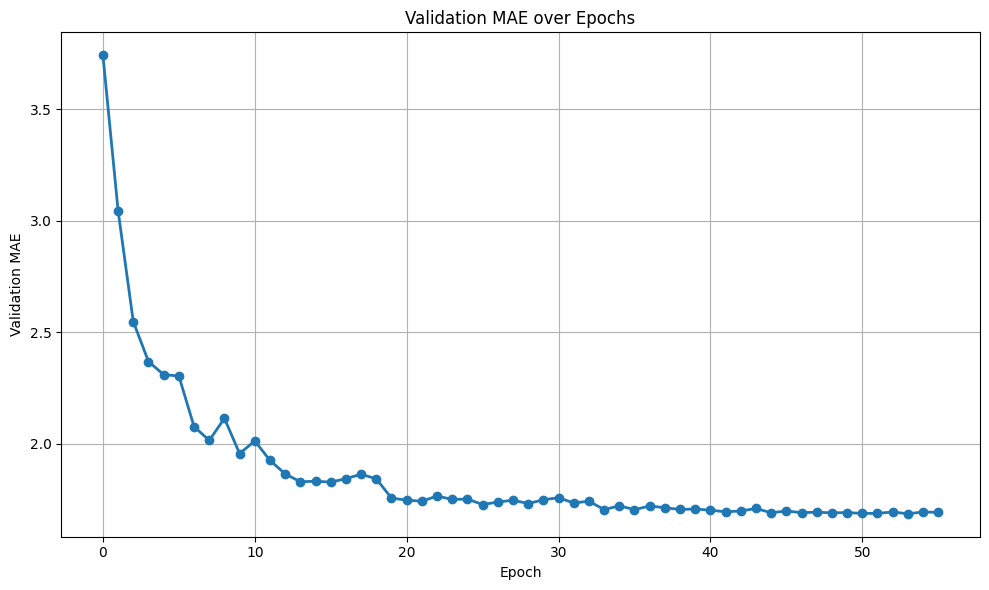

In [ ]:
val_mae_list = [
    3.7432, 3.0451, 2.5470, 2.3683, 2.3092, 2.3032, 2.0763, 2.0139, 2.1131, 1.9550,
    2.0118, 1.9244, 1.8637, 1.8283, 1.8308, 1.8269, 1.8423, 1.8622, 1.8416, 1.7552,
    1.7459, 1.7408, 1.7645, 1.7492, 1.7506, 1.7263, 1.7372, 1.7457, 1.7306, 1.7474,
    1.7569, 1.7332, 1.7412, 1.7034, 1.7205, 1.7033, 1.7195, 1.7119, 1.7040, 1.7062,
    1.7006, 1.6937, 1.6971, 1.7086, 1.6891, 1.6974, 1.6897, 1.6918, 1.6888, 1.6901,
    1.6863, 1.6864, 1.6929, 1.6846, 1.6928, 1.6910
]
epochs = list(range(len(val_mae_list)))

# 绘图
plt.figure(figsize=(10, 6))
plt.plot(epochs, val_mae_list, marker='o', linestyle='-', linewidth=2)
plt.title('Validation MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Validation MAE')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Randomly sample validation dataset and Visualize the ground truth and your predictions on a 2D plane for Question 3 Problem A

In [30]:
import matplotlib.pyplot as plt
import random

def plot_trajectory(ax, pred, gt, title=None):
    ax.cla()
    # Plot the predicted future trajectory
    ax.plot(pred[0,:60,0], pred[0,:60,1], color='red', label='Predicted Future Trajectory')
    
    # Plot the ground truth future trajectory
    ax.plot(gt[0,:60,0], gt[0,:60,1], color='blue', label='Ground Truth Future Trajectory')
    
    # Optionally set axis limits, labels, and title.
    x_max = max(pred[..., 0].max(), gt[..., 0].max())
    x_min = min(pred[..., 0].min(), gt[..., 0].min())
    y_max = max(pred[..., 1].max(), gt[..., 1].max())
    y_min = min(pred[..., 1].min(), gt[..., 1].min())
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    
    if title:
        ax.set_title(title)
    
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

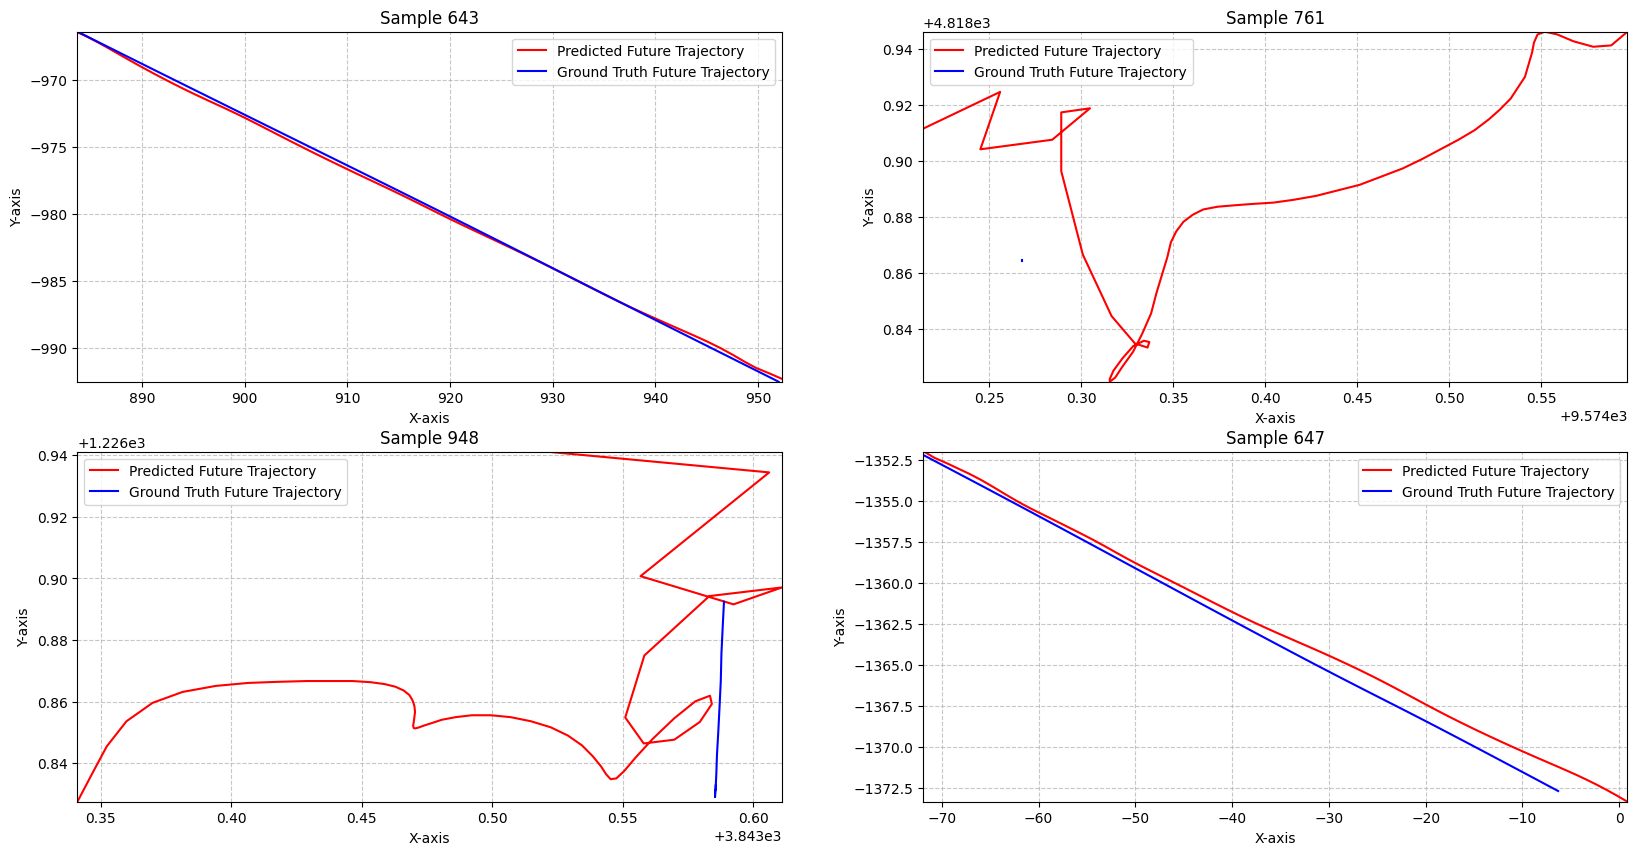

In [31]:
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

# randomly select 4 samples from the validation set
random_indices = random.sample(range(len(val_dataset)), 4)
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()  # Flatten the array to iterate single axes objects

for i, idx in enumerate(random_indices):
    batch = val_dataset[idx]
    batch = batch.to(device)
    pred = model(batch)
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0)

    pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0) * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)

    pred = pred.detach().cpu().numpy()
    gt = gt.detach().cpu().numpy()

    # Plot the trajectory using the i-th axis
    plot_trajectory(axes[i], pred, gt, title=f"Sample {idx}")

plt.show()

#### Output your predictions of the best model on the test set

In [32]:
test_dataset = TrajectoryDatasetTest(test_data, scale=scale)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                         collate_fn=lambda xs: Batch.from_data_list(xs))

best_model = torch.load("best_model.pt")
# model = LinearRegressionModel().to(device)
# model = MLP(50 * 50 * 6, 60 * 2).to(device)
# model = LSTM().to(device)
# model = LSTMwithNeighbors().to(device)
model = ParallelDecoderLSTM().to(device)
# model = LSTMEncoderDecoder().to(device)
# model = LearnedVelocityCV(50 * 50 * 6, 60 * 2).to(device)

model.load_state_dict(best_model)
model.eval()

pred_list = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred_norm = model(batch)
        
        # Reshape the prediction to (N, 60, 2)
        pred = pred_norm * batch.scale.view(-1,1,1) + batch.origin.unsqueeze(1)
        pred_list.append(pred.cpu().numpy())
pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
output_df.index.name = 'index'
output_df.to_csv('submission.csv', index=True)

## Step 4: Summarize your experiments and results in table and figures in the submitted PDF file for Question 3 Problem A

## Step 5: Analyze the results, identify the issues and plan for the improvement in the submitted PDF file for Question 3 Problem B